# OCR tables and parse the output

In this tutorial, we will illustrate how easily the `layoutparser` APIs can be used for  

1. Recognizing texts in images and store the results with the specified OCR engine
2. Postprocessing of the textual results to create structured data 


In [1]:
import layoutparser as lp 
ocr_agent = lp.TesseractAgent(languages='eng')
import matplotlib.pyplot as plt
%matplotlib inline 
import pdf2image
import pandas as pd
import numpy as np
import cv2
import math

## Initiate GCV OCR engine and check the image 

Currently, `layoutparser` supports two types of OCR engines: Google Cloud Vision and Tesseract OCR engine. And we are going to provide more support in the future. In this toturial, we will use the Google Cloud Vision engine as an example.

In [2]:
ocr_agent = lp.GCVAgent.with_credential("enter api credentials",
                                       languages = ['en'])
#The language hints 

The `language_hints` tells the GCV which langeuage shall be used for OCRing. For a detailed explanation, please check [here](https://cloud.google.com/vision/docs/languages).

The `example-table` is a scan with complicated table structures from https://stacks.cdc.gov/view/cdc/42482/. 

2


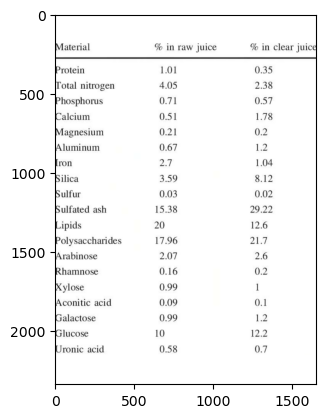

In [3]:
pdf_file= 'examp2.pdf' # Adjust the filepath of your input image accordingly

# images = np.asarray(pdf2image.convert_from_path(pdf_file)[0])
images = pdf2image.convert_from_path(pdf_file)
print(len(images))
for i, image in enumerate(images):
    # Process each page separately
    
    plt.imshow(image)
    i+=1

# image = cv2.imread('exampletable.jpeg')
# plt.imshow(image);


In [4]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],#0.5 is thresold value lesser high noice,
                                 #higher thres means higher risk of missing one or more text regions
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})


{157: ['Atomic', 'Number', '101', '102', '103', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', None], 508: ['Name', 'Unnilunium', 'Unnilbium', 'Unniltrium', 'Unnilquadium', 'Unnilpentium', 'Unnilhexium', 'Unnilseptium', 'Unniloctium', 'Unnilennium', 'Unnnillium', 'Unununnium', 'Ununbium', 'Ununtrium', 'Ununquadium', 'Ununpentium', 'Ununhexium', 'Ununseptium', 'Ununoctium', 'be'], 860: ['Symbol', 'Unu', 'Unb', 'Unt', 'Unq', 'Unp', 'Unh', 'Uns', 'Uno', 'Une', 'Uun', 'Uuu', 'Uub', 'Uut', 'Uuq', 'Uup', 'Uuh', 'Uus', 'Uuo', None]}
       157           508     860
0   Atomic          Name  Symbol
1   Number    Unnilunium     Unu
2      101     Unnilbium     Unb
3      102    Unniltrium     Unt
4      103  Unnilquadium     Unq
5      105  Unnilpentium     Unp
6      106   Unnilhexium     Unh
7      107  Unnilseptium     Uns
8      108   Unniloctium     Uno
9      109   Unnilennium     Une
10     110    Unnnillium     Uun
11     111    Unununn

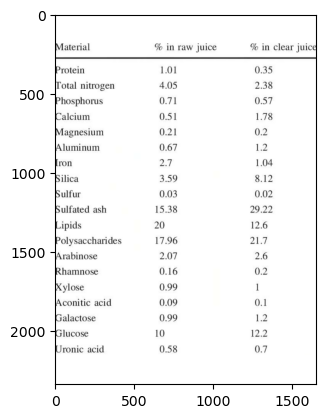

In [14]:
iX=0
for image in images:
    layout_result = model.detect(image)
#     print(layout_result)
    plt.imshow(image)
    iX = iX+1
    lp.draw_box(image, layout_result,  box_width=5, box_alpha=0.2, show_element_type=True)
    table_blocks = lp.Layout([b for b in layout_result if b.type=='Table'])
#     print(table_blocks) # in this case coordinates of table are 
#     table_annotations = lp.Layout().recognize(pdf_file, pages=[1], areas=table_blocks)
    lp.draw_box(image, table_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)
    res = ocr_agent.detect(np.asarray(image), return_response=True)
    texts  = ocr_agent.gather_text_annotations(res) 
#     print(texts)
    # collect all the texts without coordinates
    layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.PARA)
    # collect all the layout elements of the `WORD` level
    lp.draw_text(image, layout, font_size=12, with_box_on_text=True,
             text_box_width=1)
   
    column_dict = {}
    for block in layout:
        x_min = min(point[0] for point in block.block.points)
        x_max = max(point[0] for point in block.block.points)
        x = math.ceil((x_min+x_max)/2)
        range_x = 25
        flag = True
        for i in range(range_x):
            if x+i in column_dict:
                column_dict[x+i].append(block.text)
                flag = False
                break
            if x-i in column_dict:
                column_dict[x-i].append(block.text)
                flag = False
                break
        if flag:    
            column_dict[x] = [block.text]

    max_length = max([len(v) for v in column_dict.values()])
    column_dict = {k: v for k, v in column_dict.items() if len(v) > max_length-3}
    for key in column_dict.keys():
        column_dict[key] += [None] * (max_length - len(column_dict[key]))
    print(column_dict)
    db = pd.DataFrame(column_dict)
    print(db)
    db.to_csv("HAIBRO{}.csv".format(iX), header = False , index = False)


Layout(_blocks=[], page_data={})


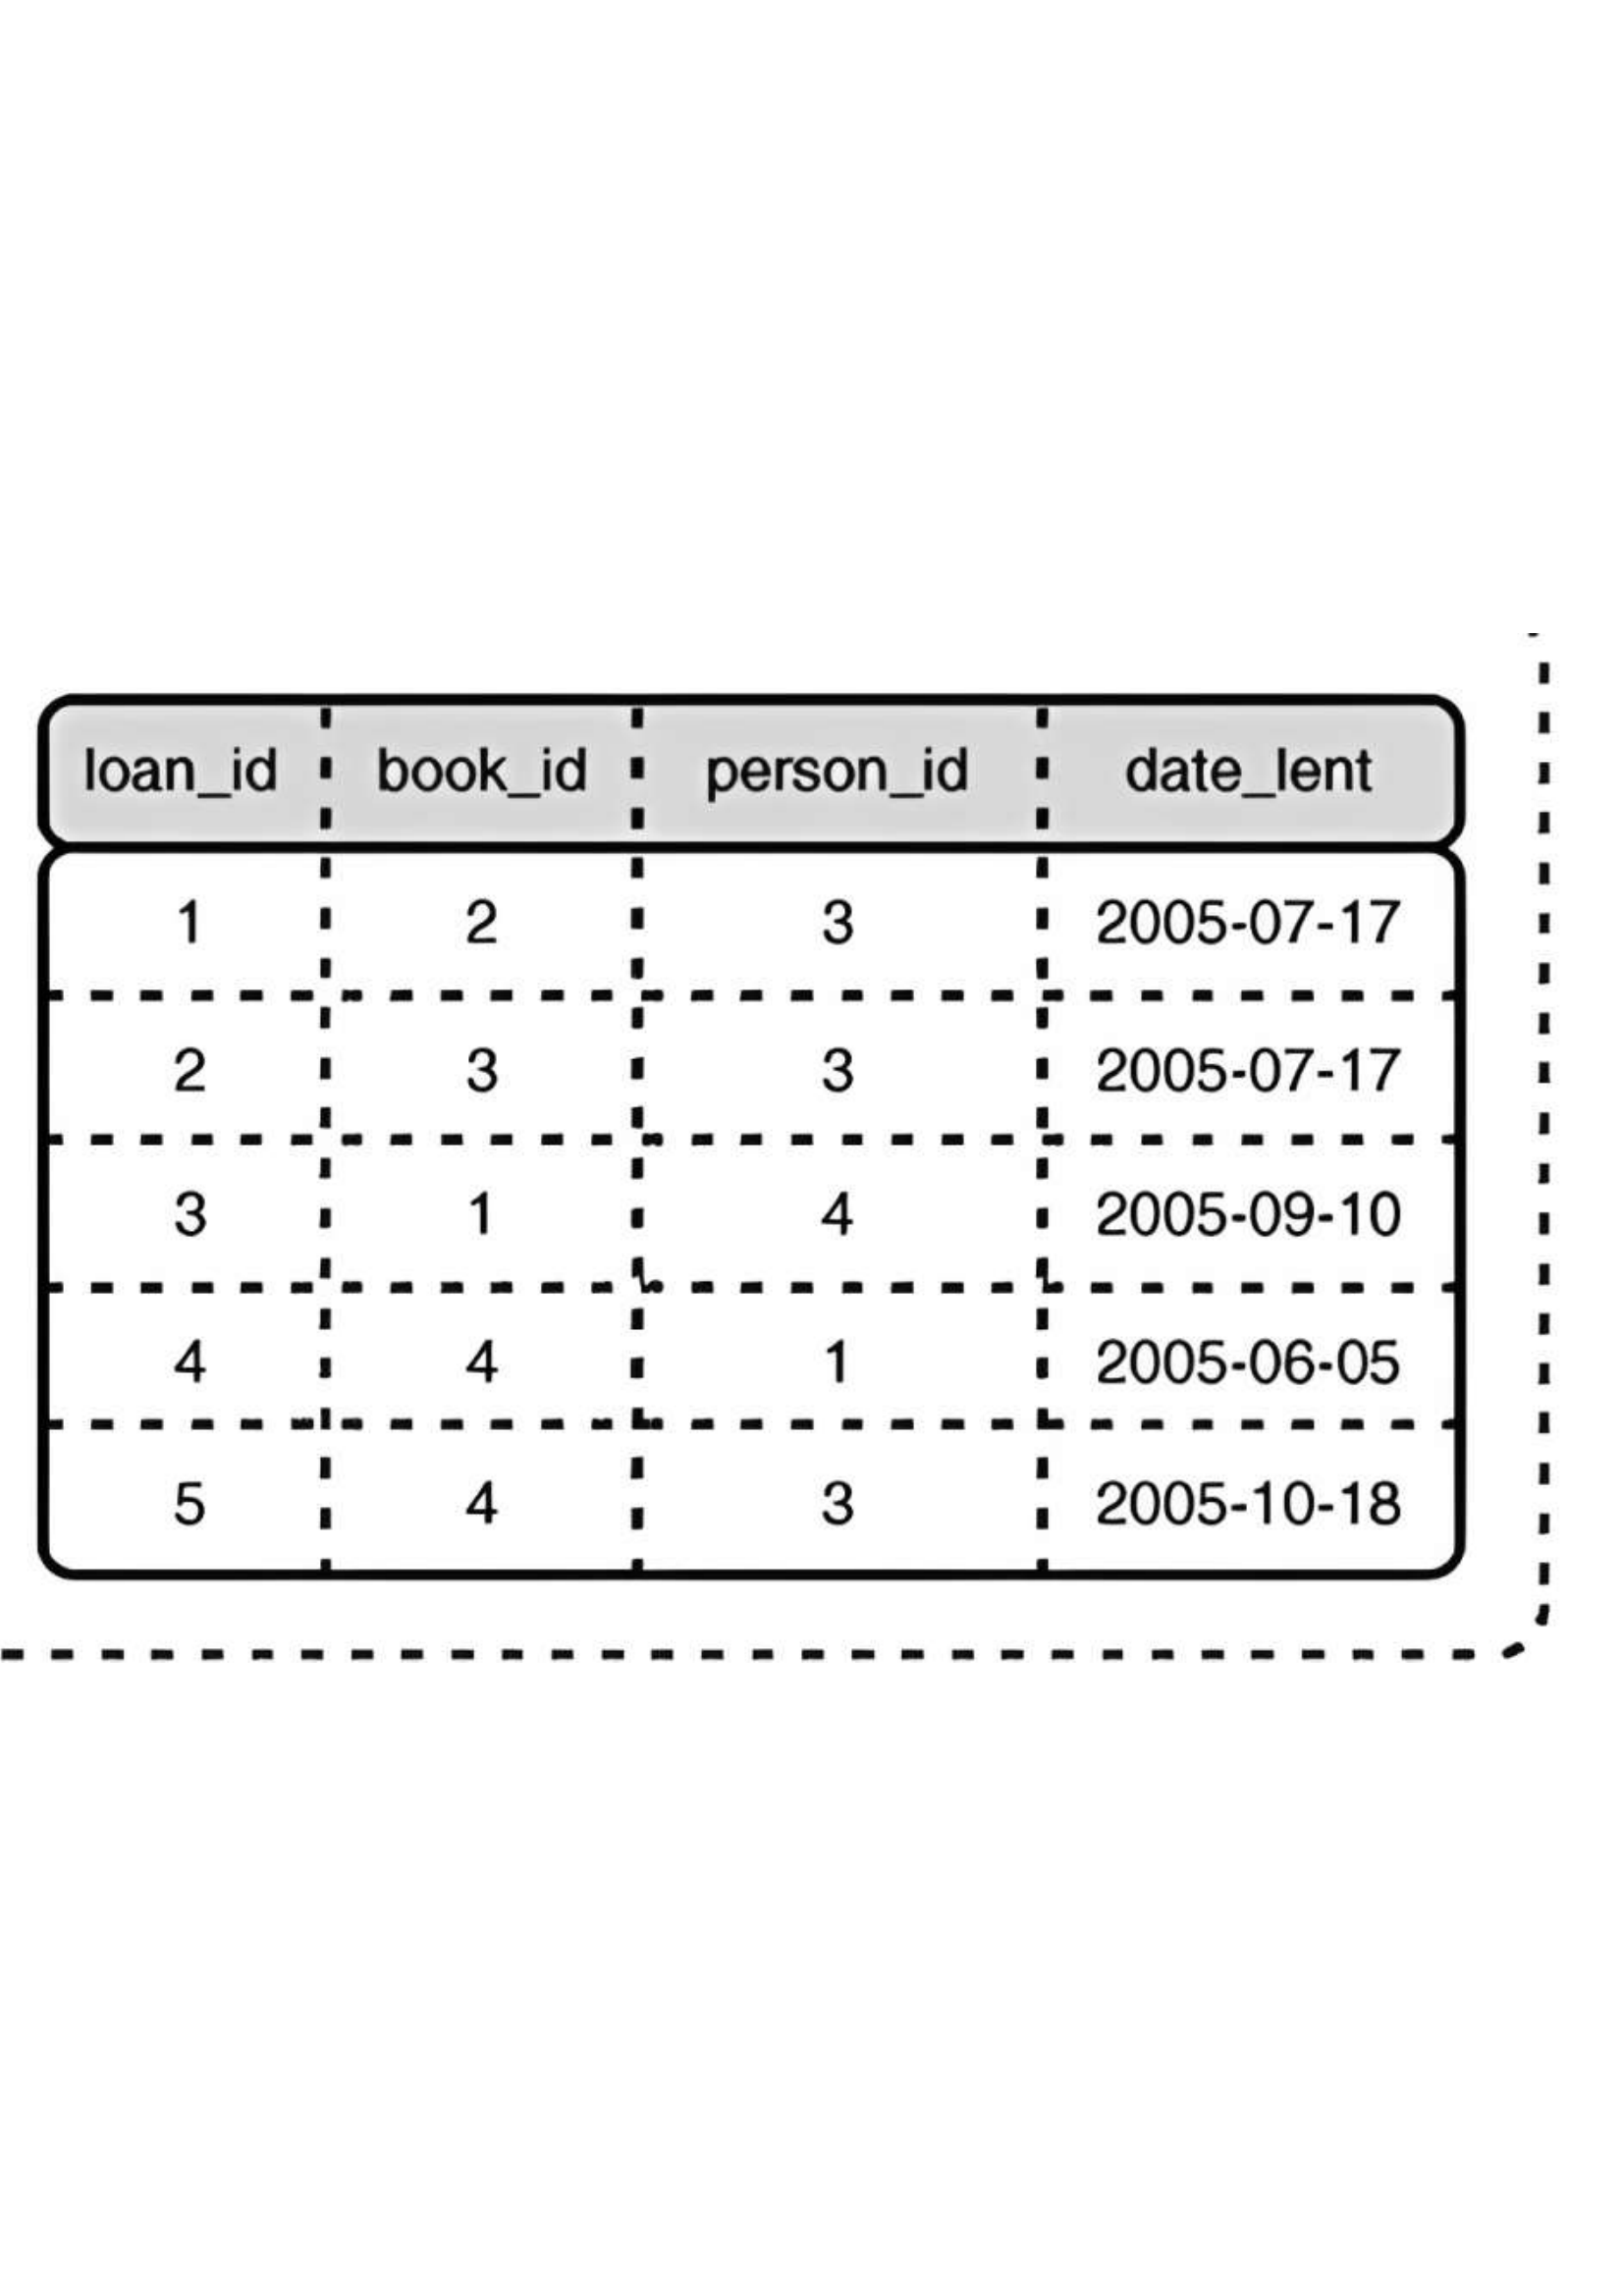

In [6]:
    table_blocks = lp.Layout([b for b in layout_result if b.type=='Table'])
    print(table_blocks) # in this case coordinates of table are 
#     table_annotations = lp.Layout().recognize(pdf_file, pages=[1], areas=table_blocks)
    lp.draw_box(image, table_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)


In [88]:
# table_blocks._blocks[0].block.x_2, table_blocks._blocks[0].block.y_2

In [89]:
# table_blocks._blocks[0].block.x_1, table_blocks._blocks[0].block.y_1 

## Load images and send for OCR


The `ocr_agent.detect` method can take the image array, or simply the path of the image, for OCR. By default it will return the text in the image, i.e., `text = ocr_agent.detect(image)`. 

However, as the layout is complex, the text information is not enough: we would like to directly analyze the response from GCV Engine. We can set the `return_response` to `True`. This feature is also supported for other OCR Engines like `TesseractOCRAgent`.

In [90]:
# res = ocr_agent.detect(image, return_response=True)
res = ocr_agent.detect(np.asarray(image), return_response=True)
# type(res)
# type(res)
# Alternative
# res = ocr_agent.detect('data/example-table.jpeg', return_response=True) 
# print(res)
print(type(res))

<class 'google.cloud.vision_v1.types.AnnotateImageResponse'>


## Parse the OCR output and visualize the layout

As defined by GCV, there are two different types of output in the response: 

1. text_annotations: 

    In this format, GCV automatically find the best aggregation 
    level for the text, and return the results in a list. We can  
    use the `ocr_agent.gather_text_annotations` to reterive this 
    type of information.

2. full_text_annotations

    To support better user control, GCV also provides the 
    `full_text_annotation` output, where it returns the hierarchical 
    structure of the output text. To process this output, we provide 
    the `ocr_agent.gather_full_text_annotation` function to aggregate 
    the texts of the given aggregation level. 
    
    There are 5 levels specified in `GCVFeatureType`, namely: `PAGE`, 
    `BLOCK`, `PARA`, `WORD`, `SYMBOL`.

In [91]:
texts  = ocr_agent.gather_text_annotations(res) 
print(texts)
    # collect all the texts without coordinates
layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.WORD)
    # collect all the layout elements of the `WORD` level

Layout(_blocks=[TextBlock(block=Quadrilateral(points=[[ 85 760]
 [283 760]
 [283 816]
 [ 85 816]], width=198, height=56), text=loan_id, id=0, type=None, parent=None, next=None, score=None), TextBlock(block=Quadrilateral(points=[[386 760]
 [596 760]
 [596 816]
 [386 816]], width=210, height=56), text=book_id, id=1, type=None, parent=None, next=None, score=None), TextBlock(block=Quadrilateral(points=[[721 760]
 [985 760]
 [985 816]
 [721 816]], width=264, height=56), text=person_id, id=2, type=None, parent=None, next=None, score=None), TextBlock(block=Quadrilateral(points=[[1053  760]
 [1064  760]
 [1064  816]
 [1053  816]], width=11, height=56), text=▪, id=3, type=None, parent=None, next=None, score=None), TextBlock(block=Quadrilateral(points=[[1146  759]
 [1398  764]
 [1397  810]
 [1145  805]], width=253, height=51), text=date_lent, id=4, type=None, parent=None, next=None, score=None), TextBlock(block=Quadrilateral(points=[[178 916]
 [205 916]
 [205 961]
 [178 961]], width=27, height=4

And we can use the `draw_box` or `draw_text` functions to quickly visualize the detected layout and text information.


These functions are highly customizable. You can change styles of the drawn boxes and texts easily. Please check the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/visualization.html#layoutparser.visualization.draw_text) for the detailed explanation of the configurable parameters. 

As shown below, the `draw_text` function generates a visualization that:

1. it draws the detected layout with text on the left side and shows the original image on the right canvas for comparison.
2. on the text canvas (left), it also draws a red bounding box for each text region.

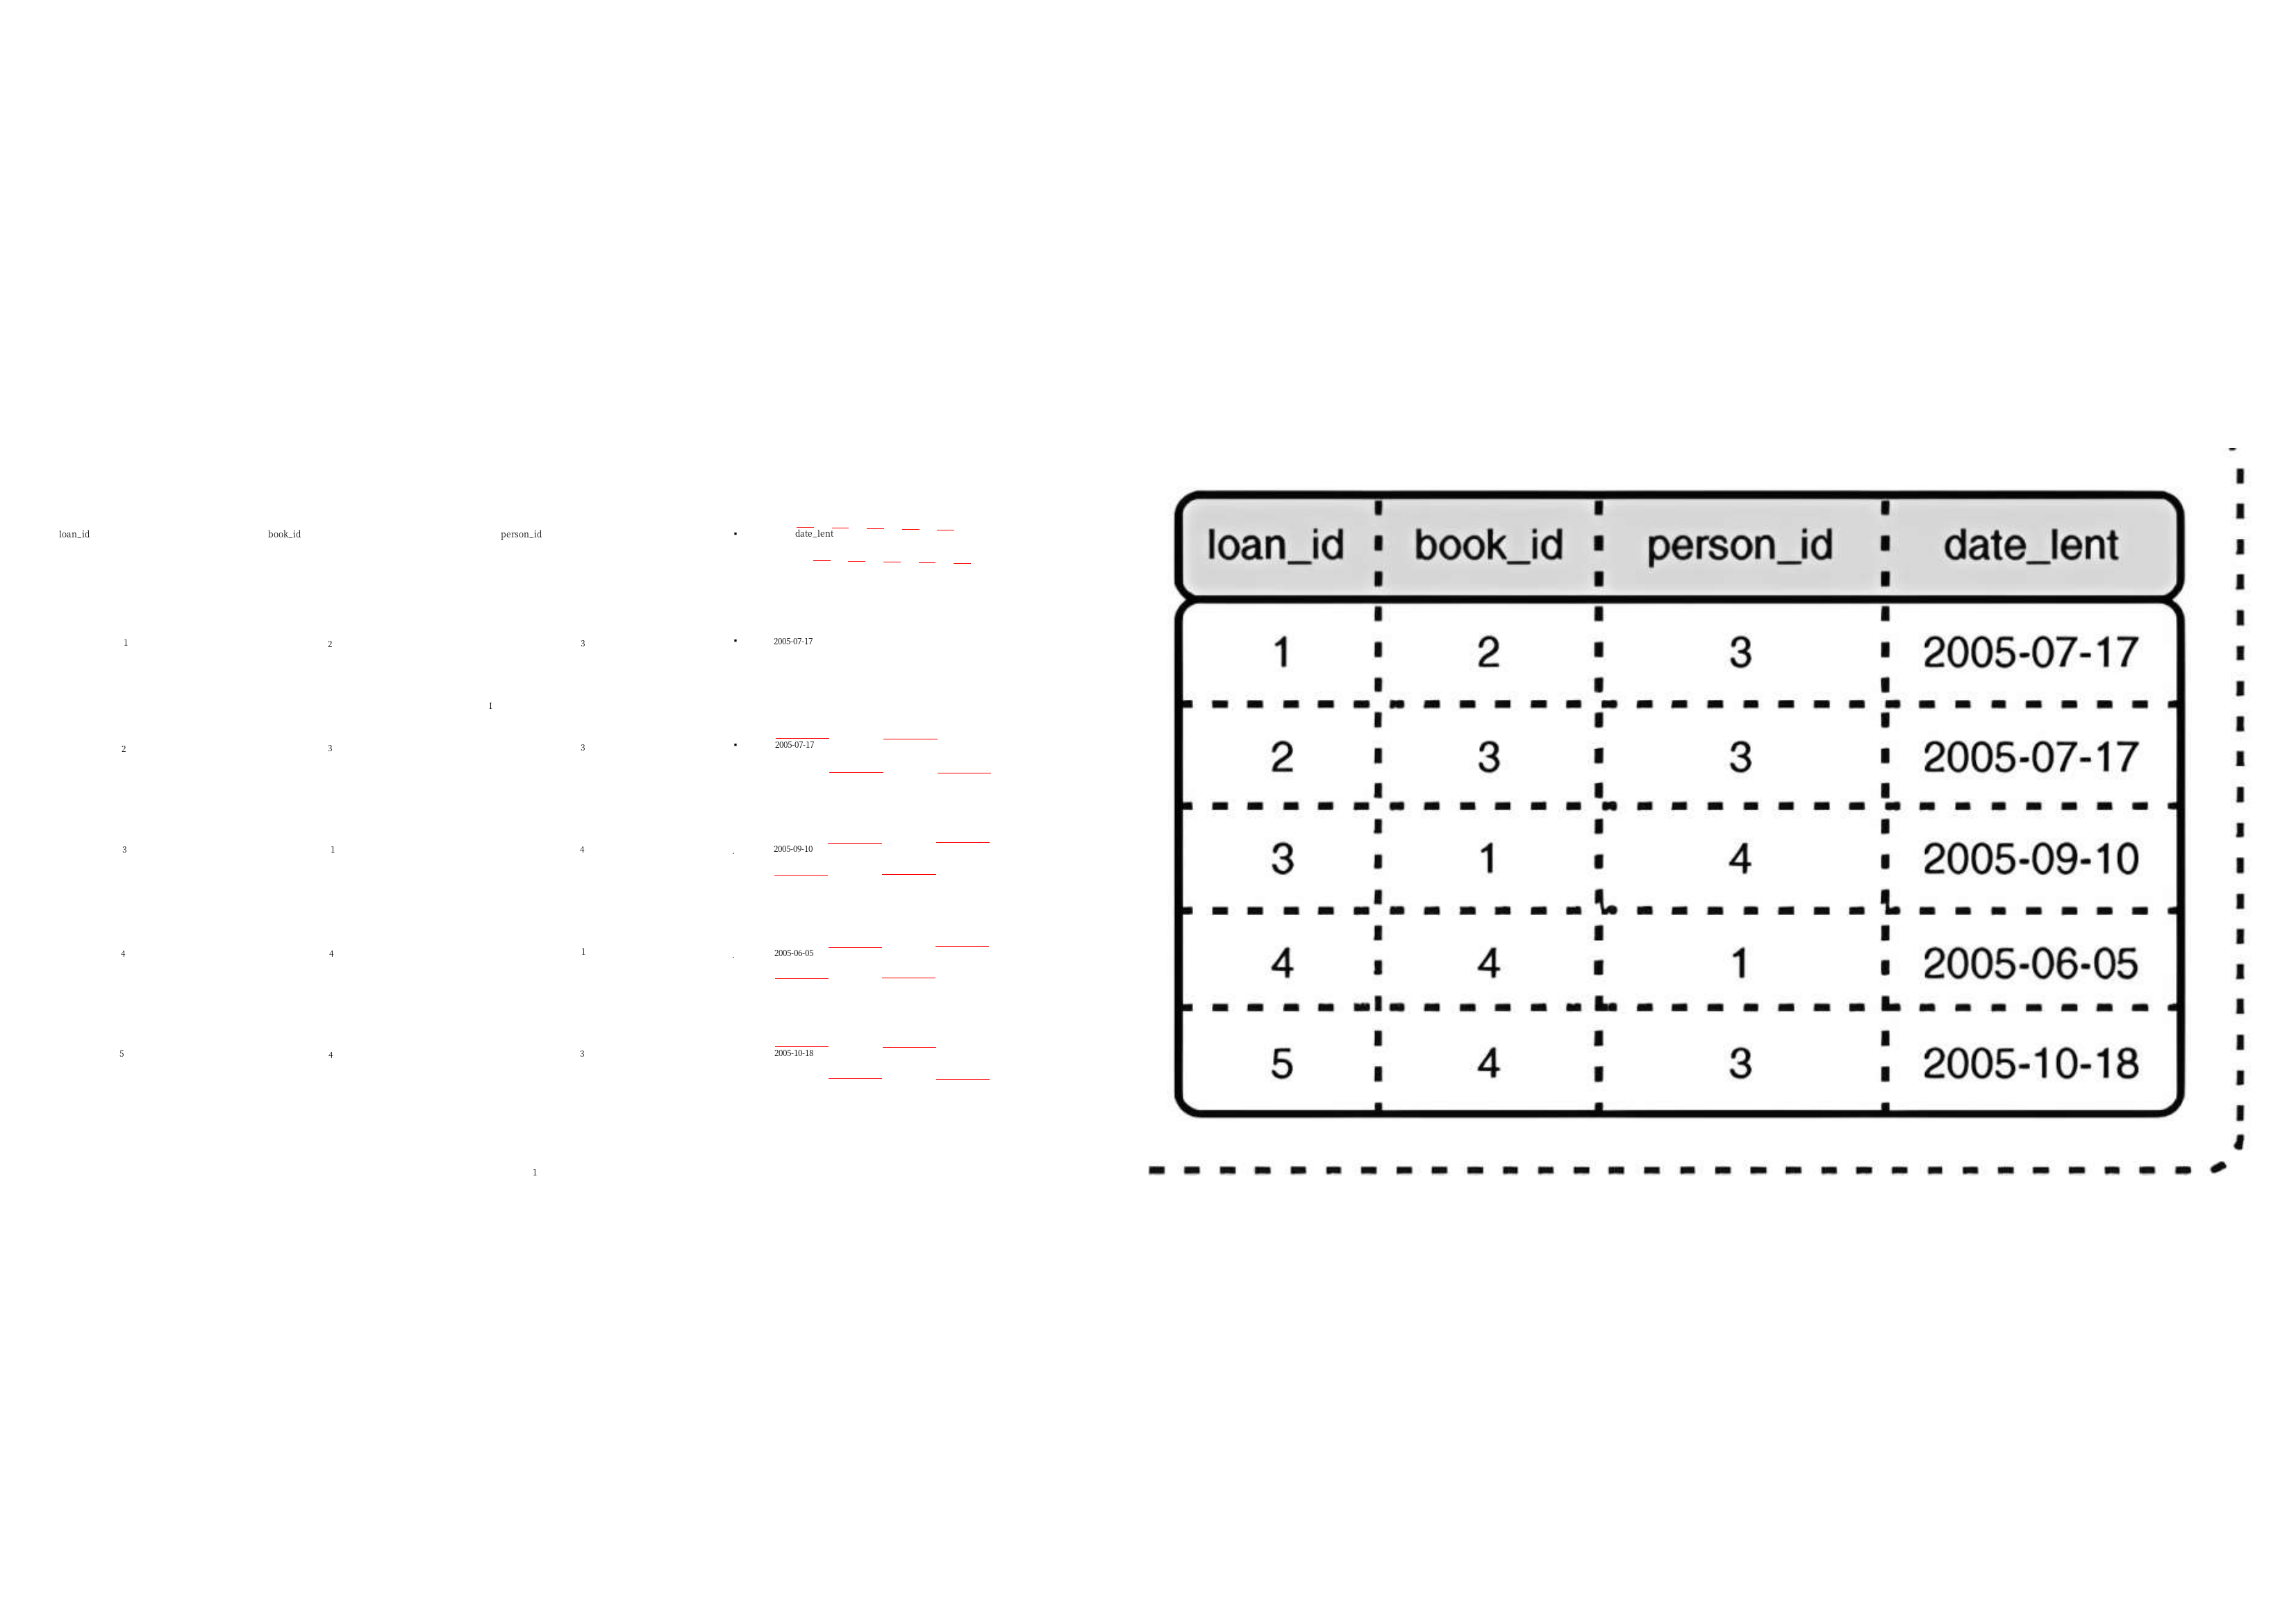

In [92]:
lp.draw_text(image, layout, font_size=12, with_box_on_text=True,
             text_box_width=1)

In [93]:
# #just for checking layout number
# lp.draw_box(image, layout, box_width=3, color_map=color_map ,show_element_id= True)
# type(layout)
# print(color_map)

In [94]:
# table_extractor = model.detect(image)
# tables = table_extractor.extract(layout)

# # Get the column boundaries for each table
# for table in tables:
#     columns = table.get_columns()
#     for column in columns:
#         print(column)

In [97]:
import pandas as pd
import math
column_dict = {}
for block in layout:
    x_min = min(point[0] for point in block.block.points)
    x_max = max(point[0] for point in block.block.points)
    x = math.ceil((x_min+x_max)/2)
    range_x = 20
    flag = True
    for i in range(range_x):
        if x+i in column_dict:
            column_dict[x+i].append(block.text)
            flag = False
            break
        if x-i in column_dict:
            column_dict[x-i].append(block.text)
            flag = False
            break
    if flag:    
        column_dict[x] = [block.text]

max_length = max([len(v) for v in column_dict.values()])
column_dict = {k: v for k, v in column_dict.items() if len(v) == max_length}
print(column_dict)
db = pd.DataFrame(column_dict)
db.to_csv("output.csv", header = False , index = False)


{184: ['loan_id', '1', '2', '3', '4', '5'], 491: ['book_id', '2', '3', '1', '4', '4'], 853: ['person_id', '3', '3', '4', '1', '3'], 1272: ['date_lent', '2005-07-17', '2005-07-17', '2005-09-10', '2005-06-05', '2005-10-18']}


In [15]:

filtered_residence = layout.filter_by(
    lp.Rectangle(x_1=table_blocks._blocks[0].block.x_1, y_1=table_blocks._blocks[0].block.y_1, 
                 x_2=table_blocks._blocks[0].block.x_2, y_2=table_blocks._blocks[0].block.y_2)
)
lp.draw_text(image, filtered_residence, font_size=16)
residence_annotations = [block for block in filtered_residence if block.type== "Text"]
# print(residence_annotations)
# residence_annotations.sort(key= lambda x:x.geometry[0][1])
data = []
import csv

with open('output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for row in table.df:
        writer.writerow(row)

# print()
# print(filtered_residence)

NameError: name 'table_block' is not defined

## Filter the returned text blocks 

We find the coordinates of residence column are in the range of $y\in(300,833)$ and $x\in(132, 264)$. The `layout.filter_by` function can be used to fetch the texts in the region. 

Note: As the OCR engine usually does not provide advanced functions like table detection, the coordinates are found manually by using some image inspecting tools like GIMP.

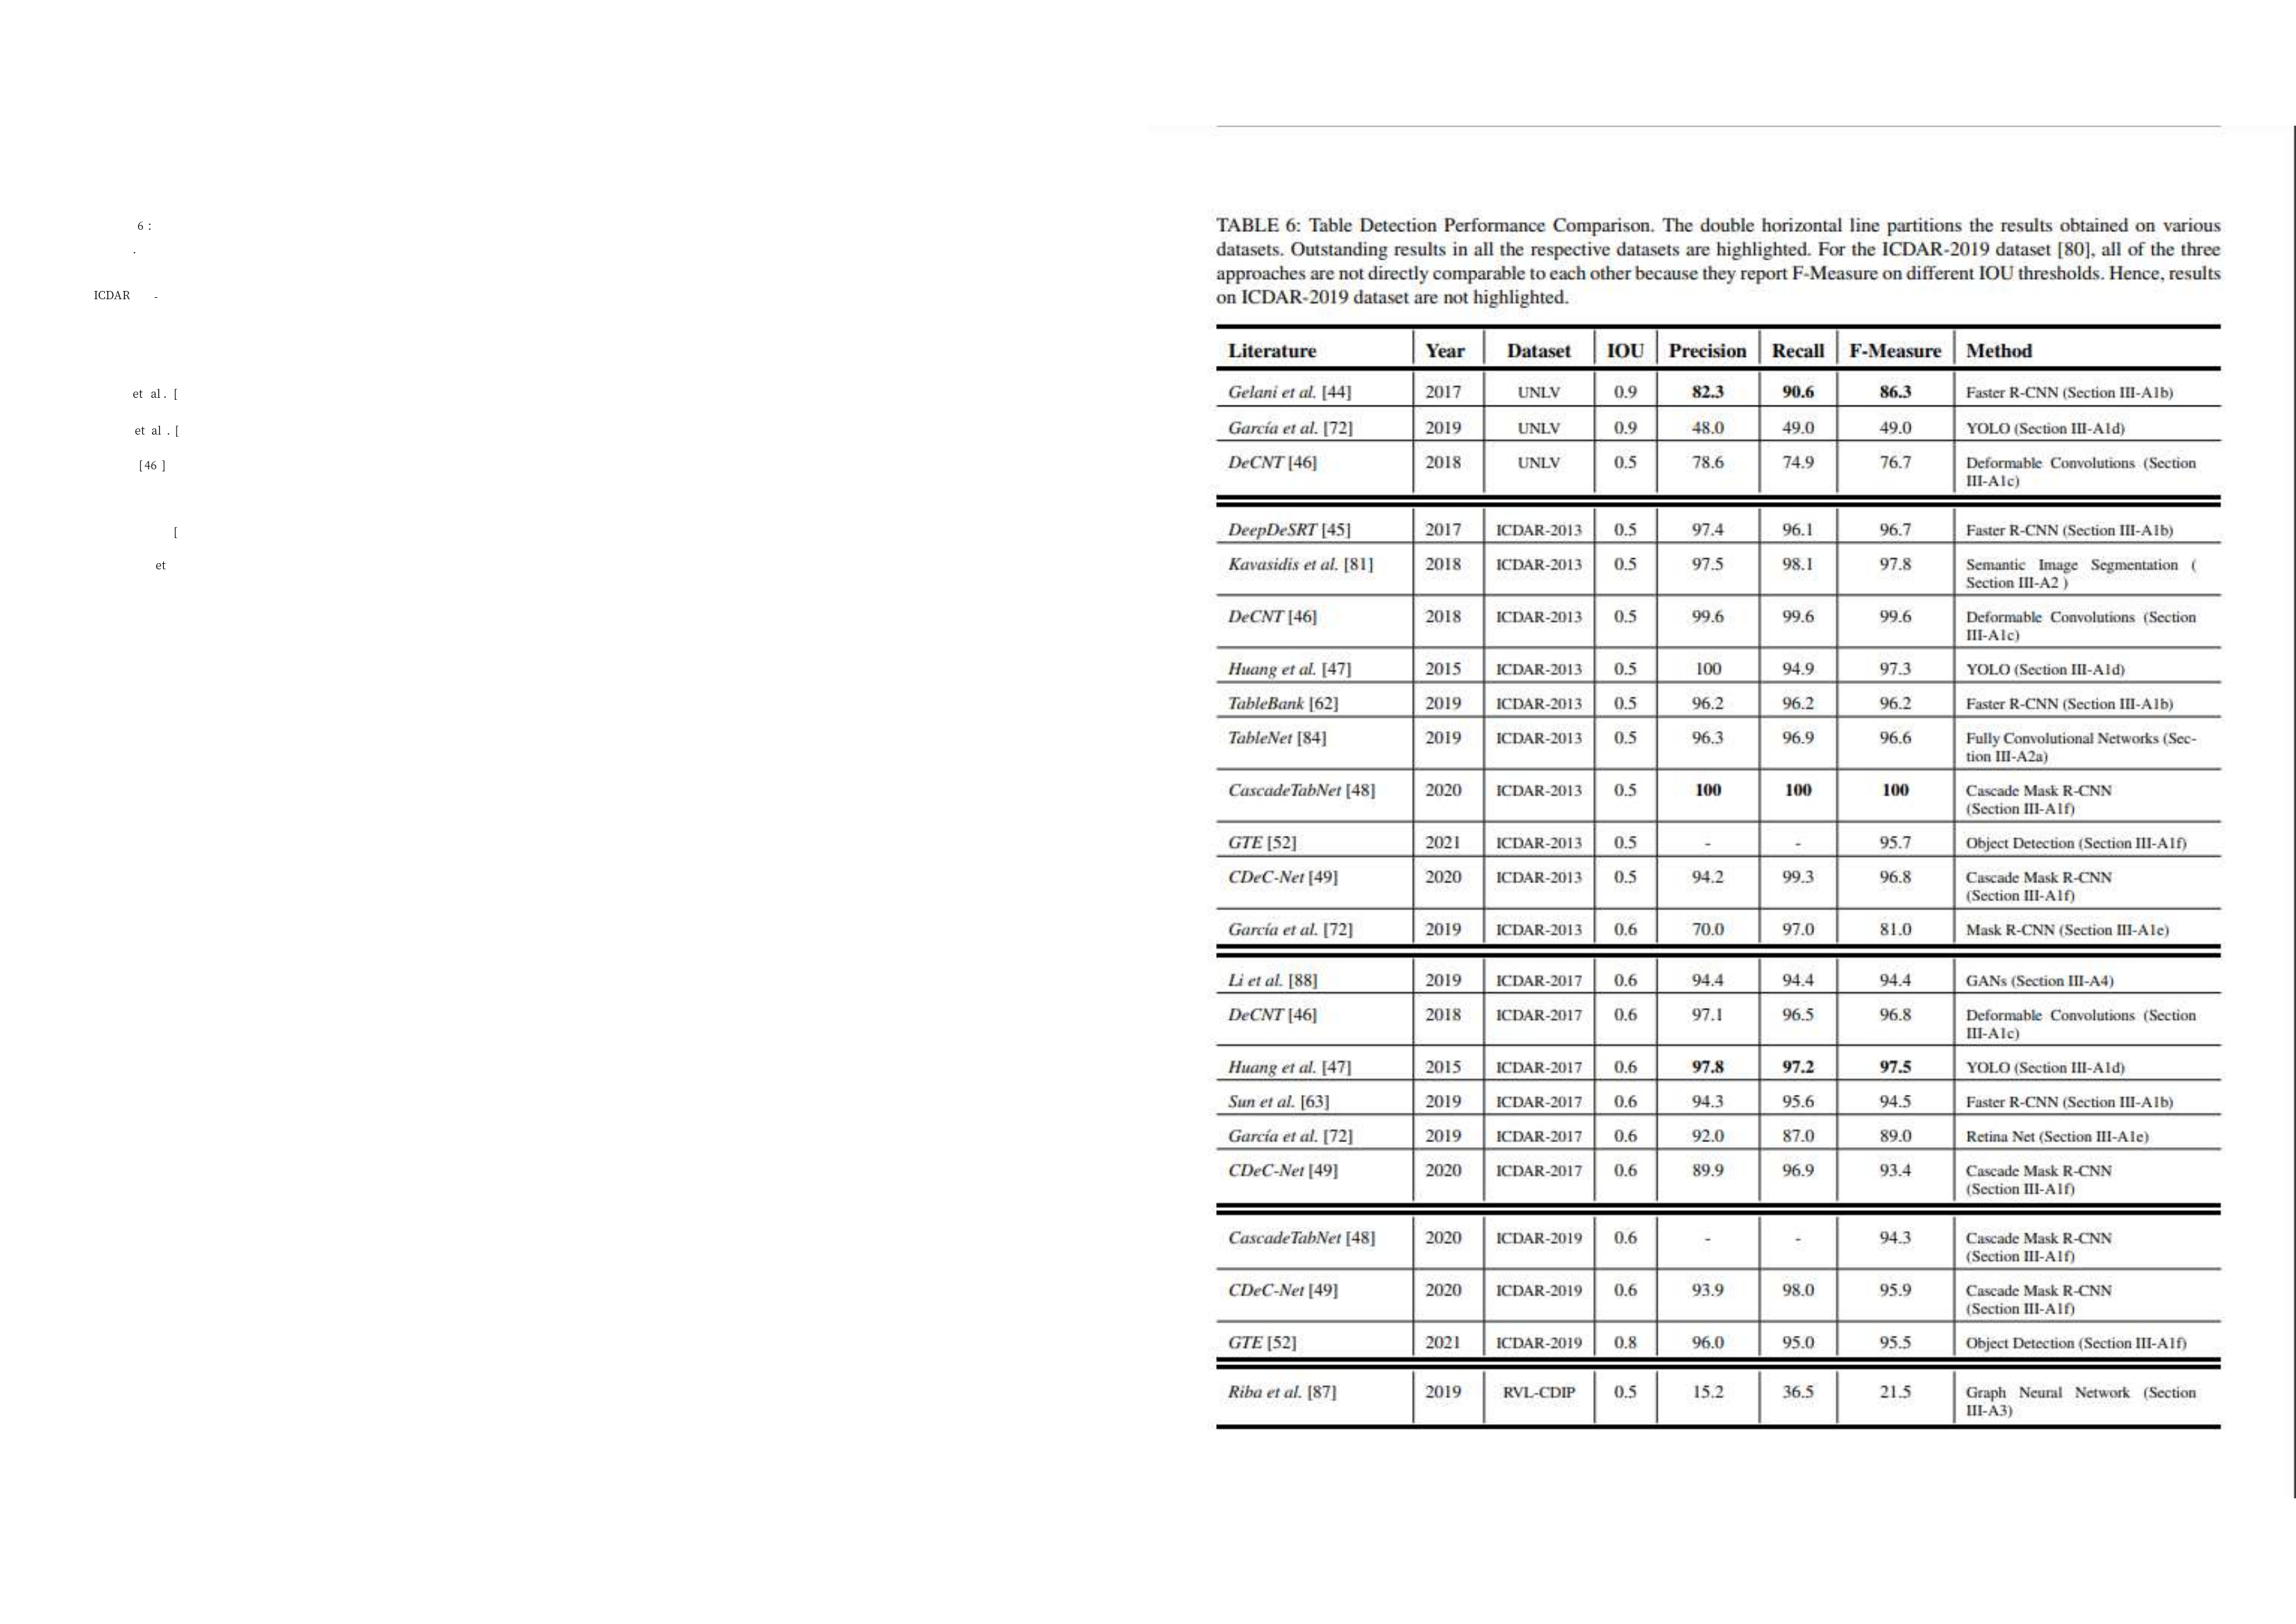

In [23]:
filtered_residence = layout.filter_by(
    lp.Rectangle(x_1=132, y_1=300, x_2=264, y_2=840)
)
lp.draw_text(image, filtered_residence, font_size=16)

And similarily, we can do that for the `lot_number` column. As sometimes there could be irregularities in the layout as well as the OCR outputs, the `layout.filter_by` function also supports a `soft_margin` argument to handle this issue and generate more robust outputs. 


In [15]:
# filter_lotno = layout.filter_by(
#     lp.Rectangle(x_1=810, y_1=300, x_2=910, y_2=840),
#     soft_margin = {"left":10, "right":20} # Without it, the last 4 rows could not be included
# )
# lp.draw_text(image, filter_lotno, font_size=16)

In [16]:
# filter_remarks = layout.filter_by(
#     lp.Rectangle(x_1=9, y_1=320, x_2=1040, y_2=840),
#     soft_margin = {"left":10, "right":20} # Without it, the last 4 rows could not be included
# )
# lp.draw_text(image, filter_lotno, font_size=16)

# from layoutparser import TextBox, Layout

# # Assume `residence_region` is a tuple of (x_min, y_min, x_max, y_max)
# filtered_blocks = []
# for block in layout:
#     if isinstance(block, TextBox):
#         bbox = block.coordinates
#         if (residence_region[0] <= bbox[0] <= bbox[2] <= residence_region[2] and 
#             residence_region[1] <= bbox[1] <= bbox[3] <= residence_region[3]):
#             filtered_blocks.append(block)

# # Convert the filtered blocks into a new layout object
# filtered_layout = Layout(filtered_blocks)


### Group Rows based on hard-coded parameteres

As there are 13 rows, we can iterate the rows and fetch the row-based information:

In [17]:
y_0 = table_blocks._blocks[0].block.y_1
n_rows = len(table_annotations.get_words(textlines=True))
height = int((table_blocks._blocks[0].block.y_2-y_0) /n_rows)
x_0 = table_blocks._blocks[0].block.x_1
n_cols = len(table_annotations.get_words(textlines=True, box=[x_0, y_0, x_0 + 10, y_0 + height]))
width = int((table_blocks._blocks[0].block.x_2 - x_0) / n_cols)

# Extract the data from the table
table_data = []
for row in range(n_rows):
    table_row = []
    for col in range(n_cols):
        x1 = x_0 + col * width
        y1 = y_0 + row * height
        x2 = x_0 + (col + 1) * width
        y2 = y_0 + (row + 1) * height
        cell_annotations = table_annotations.filter_by(lp.Rectangle(x_1=x1, y_1=y1, x_2=x2, y_2=y2))
        cell_text = ' '.join(cell_annotations.get_texts())
        table_row.append(cell_text)
    table_data.append(table_row)

# Create a pandas DataFrame with the extracted data
df = pd.DataFrame(table_data[1:], columns=table_data[0])

# Save the DataFrame as a CSV file
df.to_csv('extracted_data.csv', index=False)
# n_cols = len(table_annotations.get_words(textlines= True, box = [x_0,y_0,]))
# y_1 = y_0+n_rows*height

# row = []
# for y in range(y_0, y_1, height):
#     s
#     interval = lp.Interval(y,y+height, axis='y't)
#     residence_row = filtered_residence.\
#         filter_by(interval).\
#         get_texts()

#     lotno_row = filter_lotno.\
#         filter_by(interval).\
#         get_texts()
    
#     row.append([''.join(residence_row), ''.join(lotno_row)])

NameError: name 'table_annotations' is not defined

In [26]:
row

[['TaskII', ''],
 ['', 'canbe'],
 ['The', ''],
 ['', '52%.'],
 ['a', 'dataset'],
 ['', ''],
 ['After', 'theF1'],
 ['model', 'B.'],
 ['', ''],
 ['scratch.', ''],
 ['', ''],
 ['', ''],
 ['', '']]

### An Alternative Method - Adaptive Grouping lines based on distances 

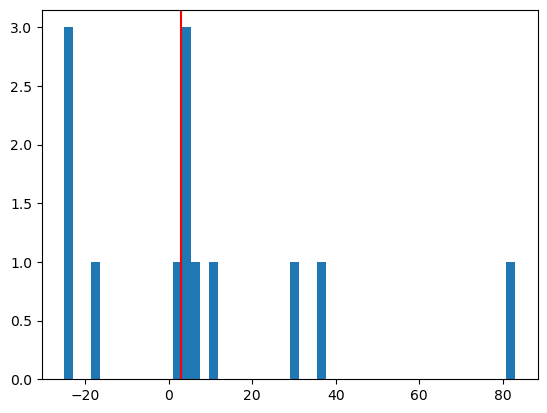

In [27]:
blocks = filter_lotno

blocks = sorted(blocks, key = lambda x: x.coordinates[1])
    # Sort the blocks vertically from top to bottom 
distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])
    # Calculate the distances: 
    # y coord for the upper edge of the bottom block - 
    #   y coord for the bottom edge of the upper block
    # And convert to np array for easier post processing
plt.hist(distances, bins=50);
plt.axvline(x=3, color='r');
    # Let's have some visualization 

According to the distance distribution plot, as well as the OCR results visualization, we can conclude:

- For the negative distances, it's because there are texts in the same line, e.g., "Los Angeles"
- For the small distances (indicated by the red line in the figure), they are texts in the same table row as the previous one 
- For larger distances, they are generated from texts pairs of different rows 

In [28]:
distance_th = 0

distances = np.append([0], distances) # Append a placeholder for the first word
block_group = (distances>distance_th).cumsum() # Create a block_group based on the distance threshold 

block_group

array([0, 0, 1, 2, 3, 3, 3, 4, 5, 6, 6, 7, 8, 9])

In [29]:
# Group the blocks by the block_group mask 
grouped_blocks = [[] for i in range(max(block_group)+1)]
for i, block in zip(block_group, blocks):
    grouped_blocks[i].append(block) 

Finally let's create a function for them

In [30]:
def group_blocks_by_distance(blocks, distance_th):

    blocks = sorted(blocks, key = lambda x: x.coordinates[1])
    distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])

    distances = np.append([0], distances)
    block_group = (distances>distance_th).cumsum()

    grouped_blocks = [lp.Layout([]) for i in range(max(block_group)+1)]
    for i, block in zip(block_group, blocks):
        grouped_blocks[i].append(block) 
        
    return grouped_blocks

In [31]:
A = group_blocks_by_distance(filtered_residence, 5)
B = group_blocks_by_distance(filter_lotno, 10) 

# And finally we combine the outputs 
height_th = 30
idxA, idxB = 0, 0

result = []
while idxA < len(A) and idxB < len(B):
    ay = A[idxA][0].coordinates[1]
    by = B[idxB][0].coordinates[1]
    ares, bres = ''.join(A[idxA].get_texts()), ''.join(B[idxB].get_texts())
    if abs(ay - by) < height_th:
        idxA += 1; idxB += 1
    elif ay < by:
        idxA += 1; bres = ''
    else: 
        idxB += 1; ares = ''
    result.append([ares, bres])
    
result

[['TaskII', 'canbeofF152%.dataset'],
 ['The', ''],
 [',and', ''],
 ['a', ''],
 ['After', 'totheF1'],
 ['model', 'B.'],
 ['custom', ''],
 ['scratch.', ''],
 ['transferits', 'this'],
 ['', 'based']]

As we can find, there are mistakes in the 5th and 6h row - `Riverside Co` and `LosAngeles` are wrongly combined. This is because the extra row `co` disrupted the row segmentation algorithm. 

## Save the results as a table

In [32]:
df = pd.DataFrame(row, columns=['residence', 'lot no'])
df

,residence,lot no
0,TaskII,
1,,canbe
2,The,
3,,52%.
4,a,dataset
5,,
6,After,theF1
7,model,B.
8,,
9,scratch.,


In [24]:
df.to_csv('ocred-example-table.csv', index=None)